## ADT Processing

Processing the ADTs.

In [2]:
import scanpy as sc 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
import itertools as it
import json
import requests
import seaborn as sns
import pickle as pkl
from functools import reduce

In [3]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)
print(sc.__version__)
sc.settings.n_jobs=12

1.4.5.post1


In [4]:
prefix = '/data/codec/production.run/adts/'

### Load in the Data

In [5]:
wells = dict()
for well in range(12):
    wells[well] = dict()
    wells[well]['adata'] = sc.read_10x_h5(prefix + "10x.h5s/well%d/outs/raw_feature_bc_matrix.h5" % (well + 1))
    wells[well]['adata'].var_names_make_unique()

reading /data/codec/production.run/adts/10x.h5s/well1/outs/raw_feature_bc_matrix.h5
 (0:00:07)
reading /data/codec/production.run/adts/10x.h5s/well2/outs/raw_feature_bc_matrix.h5
 (0:00:07)
reading /data/codec/production.run/adts/10x.h5s/well3/outs/raw_feature_bc_matrix.h5
 (0:00:07)
reading /data/codec/production.run/adts/10x.h5s/well4/outs/raw_feature_bc_matrix.h5
 (0:00:07)
reading /data/codec/production.run/adts/10x.h5s/well5/outs/raw_feature_bc_matrix.h5
 (0:00:07)
reading /data/codec/production.run/adts/10x.h5s/well6/outs/raw_feature_bc_matrix.h5
 (0:00:08)
reading /data/codec/production.run/adts/10x.h5s/well7/outs/raw_feature_bc_matrix.h5
 (0:00:07)
reading /data/codec/production.run/adts/10x.h5s/well8/outs/raw_feature_bc_matrix.h5
 (0:00:07)
reading /data/codec/production.run/adts/10x.h5s/well9/outs/raw_feature_bc_matrix.h5
 (0:00:07)
reading /data/codec/production.run/adts/10x.h5s/well10/outs/raw_feature_bc_matrix.h5
 (0:00:07)
reading /data/codec/production.run/adts/10x.h5s/w

Also load in the barcodes from the mRNA, so I don't have these giant matrices in memory.

In [6]:
path = prefix + '../mrna/obs/concat.bcs.txt'

with open(path,'r') as file:
    bcs = ['-'.join(i.strip().split('-')[:2]) for i in file.readlines()]

### Adjust Cell Barcodes, Filter

I'm adjusting the cell barcodes to make them match their well number, which I also did with the mRNA.

In [7]:
for well in tqdm(wells):
    wells[well]['adata'].obs_names = [i[:16] + '-%s' % well for i in wells[well]['adata'].obs_names]

Subsetting based on the mRNA barcodes.

In [9]:
for well in tqdm(wells):
    wells[well]['adata'] = wells[well]['adata'][[i for i in bcs if int(i.split('-')[-1]) == well]]

Going to use the `filter_cells` and `filter_genes` functions just to get the `n_counts` column in the `.obs` and `.var`. Not actually filtering, since I'm setting my thresholds to 0.

In [8]:
for well in wells:
    sc.pp.filter_cells(wells[well]['adata'], min_counts=0)
    sc.pp.filter_genes(wells[well]['adata'], min_counts=0)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


### Concatenate

In [9]:
concat_adts = wells[0]['adata'].concatenate(*[wells[i]['adata'] for i in range(1,12)])# I really shouldn't do this, I should go back and run cellranger aggr, but for now just concatenate

In [10]:
concat_adts.var['n_counts'] = concat_adts.var[[i for i in concat_adts.var.columns if i.startswith('n_counts')]].sum(axis=1)

### Filter Proteins, Transform Data

Trying to see if any proteins have much lower counts. We usually see even antibodies that weren't even added into the mix still showing some counts.

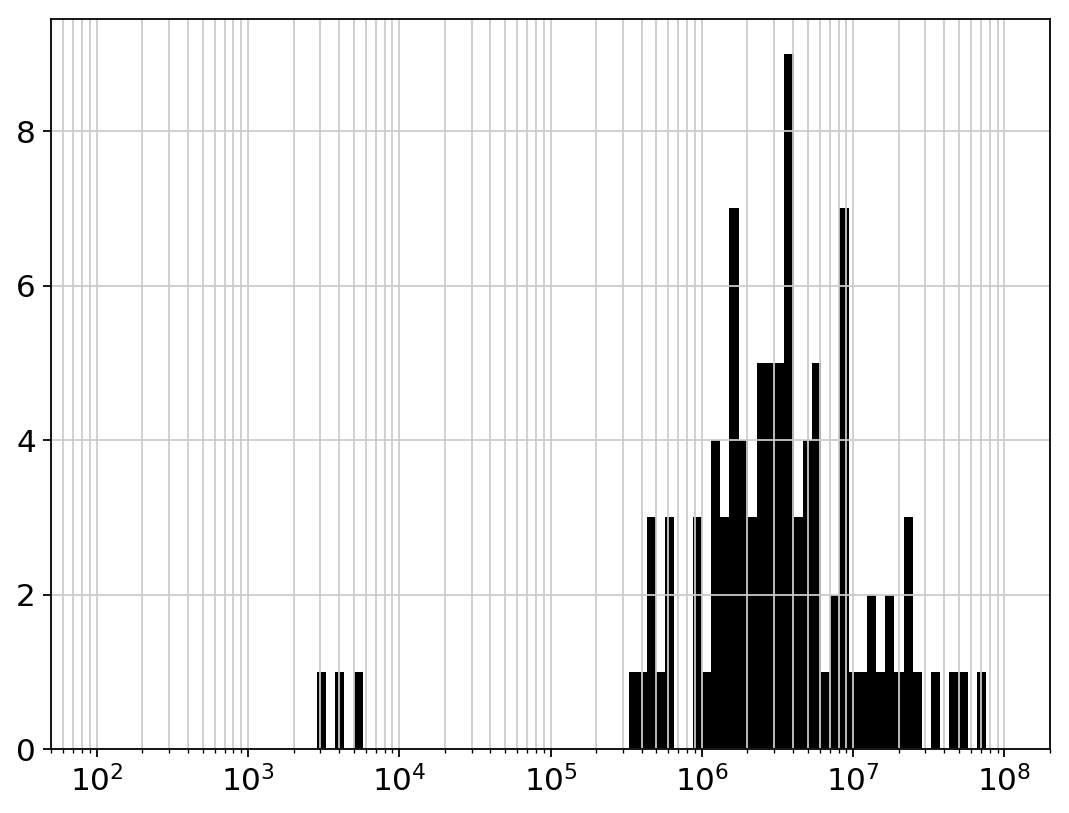

In [11]:
plt.figure(figsize=(8,6))
plt.hist(concat_adts.var['n_counts'].values, color='k', bins=np.logspace(np.log10(1e2),np.log10(1e8), 100))
plt.grid(False)
plt.grid(True, 'both', 'both')
plt.xscale('log')
# plt.yscale('log')

Going to only keep those proteins with counts > 100K, since the ones below that are probably not real.

In [12]:
concat_adts = concat_adts[:,concat_adts.var['n_counts'] > 1e5].copy()

Now normalize per cell.

In [13]:
sc.pp.normalize_per_cell(concat_adts, counts_per_cell_after=1e6)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


Now, I wanted to compare the log1p transformation I've been generally using for protein data to the CLR normalization that Monique wrote up, based on Seurat's implementation. Early on playing with ADT data, I decided that CLR was not _that_ much different from log1p. First of all, they're both monotonic transformations, and since its relative differences that are important in all single-cell seq data, I felt that it didn't really matter. Secondly, because I wasn't planning on using the protein to inform any low-level differences between the cells and simply to color by their protein expression, I didn't think that doing it the "theoretically correct way" was all that important. However, Monique mentioned that they do look different and I just want to compare here.

In [14]:
def clr_normalize_column(x):
    normed_column = np.log1p((x) / (np.exp(sum(np.log1p((x)[x > 0 ])) / len(x + 1))))
    return normed_column
def clr_normalize(x):
    normed_matrix = np.apply_along_axis(clr_normalize_column, 1, x)
    return normed_matrix

In [15]:
concat_adts_log1p = sc.pp.log1p(concat_adts, copy=True)

In [16]:
concat_adts_clr = concat_adts.copy()
concat_adts_clr.X = clr_normalize(concat_adts_clr.X.toarray())

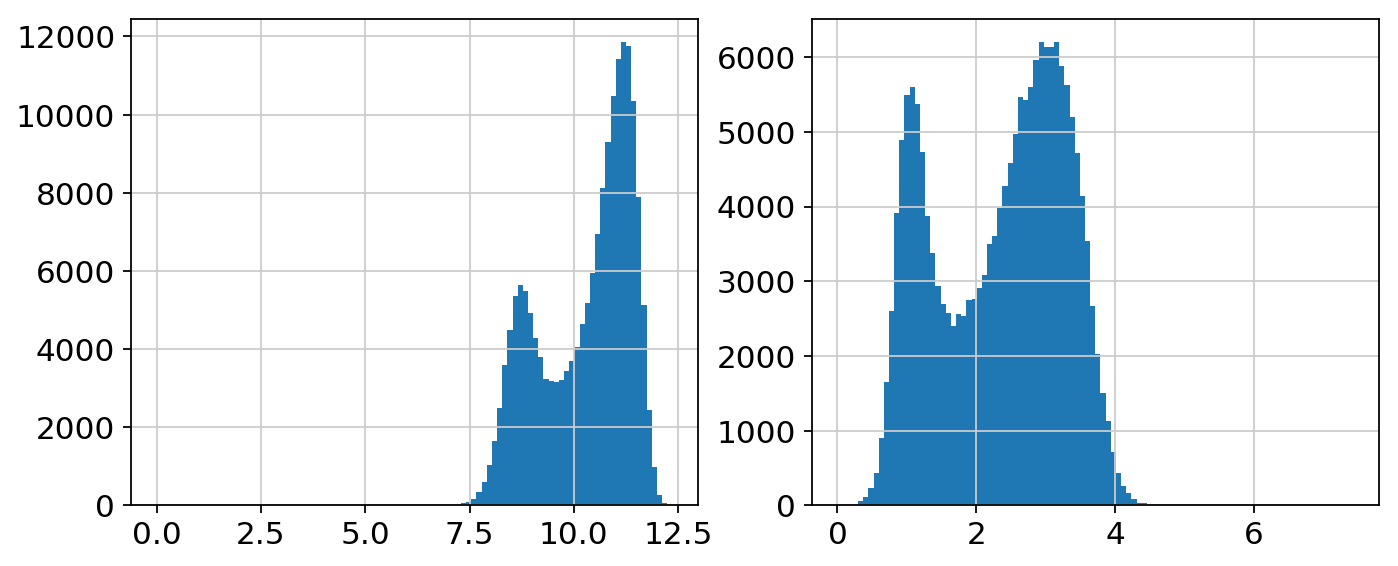

In [17]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(concat_adts_log1p.obs_vector('CD45RA|PTPRC'),bins=100);
ax[1].hist(concat_adts_clr.obs_vector('CD45RA|PTPRC'),bins=100);

So those look pretty similar. To quell concerns that the peak is half the size, I _don't_ think that it's producing half as many positive cells, I think they're just getting more spread out in terms of their expression level over that higher-valued peak.

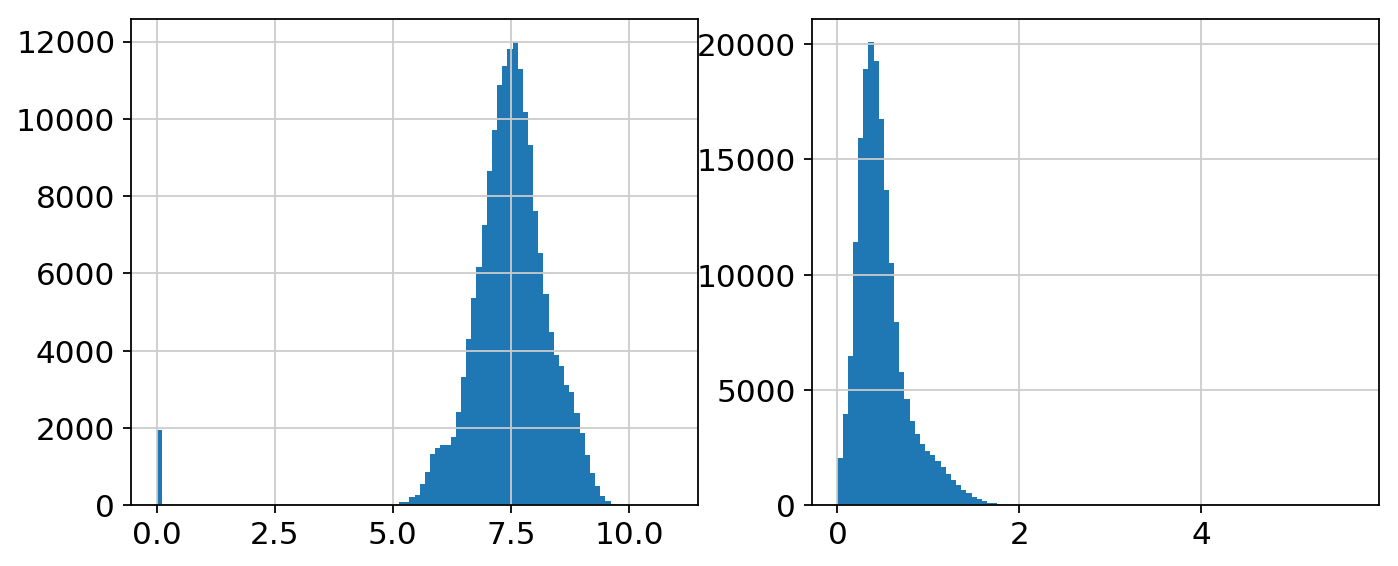

In [18]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(concat_adts_log1p.obs_vector('CD45RO|PTPRC'),bins=100);
ax[1].hist(concat_adts_clr.obs_vector('CD45RO|PTPRC'),bins=100);

This is something I _have_ noticed with the protein data: there are a very small number of cells with counts of close to or at zero while the rest of the cells show counts in the 1000s or 10s of 1000s. This becomes a problem when I scale the data, and it seems like CLR is able to diminish that effect, so that's good evidence of it being a better transformation.

This is similar to what FlowJo's biexponential scale is able to "fix" when plotting, as demonstrated here:

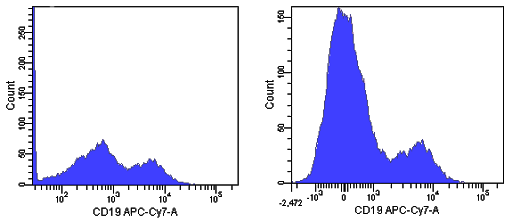

When I _was_ using log1p, I had come up with a way to correct for this by just clipping values at the "true" negative peak. Demonstrated here:

In [19]:
proteins = concat_adts_log1p.var_names

To find the lower value to clip at, I used the bins from the histogram itself, and find the first non-zero bin after the initial peak, if there _is_ an initial peak.

In [20]:
shifts = list()
for protein in tqdm(proteins):
    n, bins, patches = plt.hist(concat_adts_log1p.obs_vector(protein),bins=100)
    plt.close()
    shifts.append(bins[n.argmin() + (n[n.argmin():] > 0).argmax()])

In [21]:
new_X = concat_adts_log1p.X.toarray()
for i in tqdm(range(len(proteins))):
    new_X[:,i] = np.clip(new_X[:,i],shifts[i], np.inf)

In [22]:
concat_adts_log1p.X = new_X

In [23]:
sc.pp.scale(concat_adts_log1p, max_value=10)

    ... clipping at max_value 10


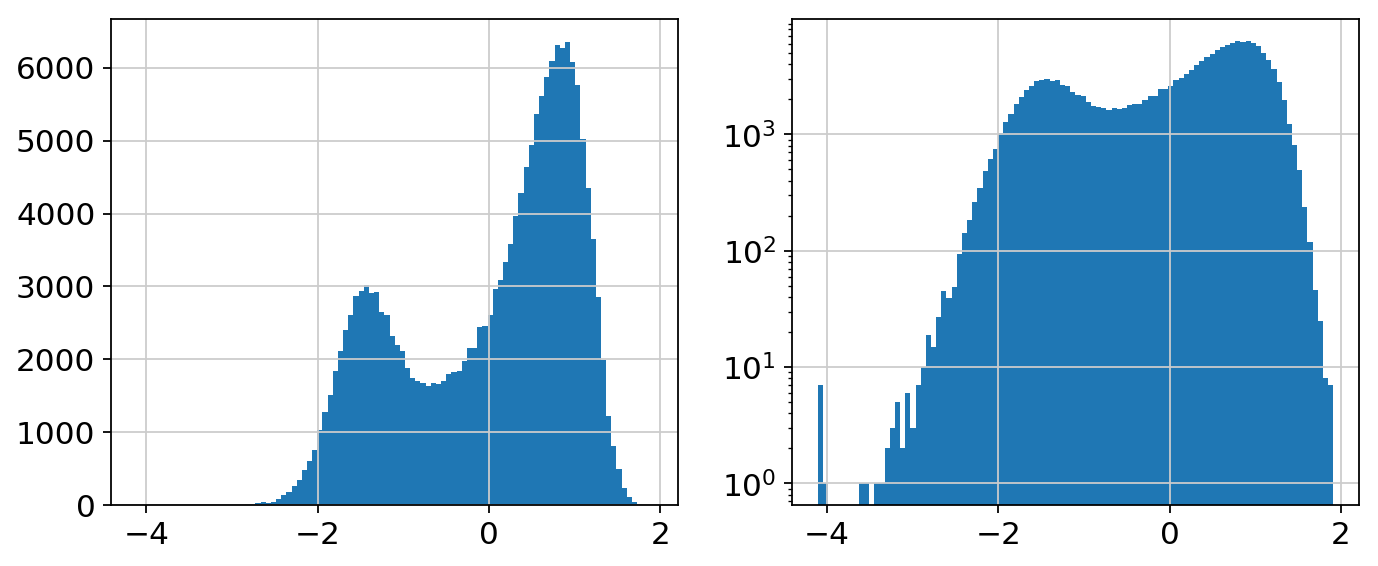

In [24]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(concat_adts_log1p.obs_vector('CD45RA|PTPRC'),bins=100);
ax[1].hist(concat_adts_log1p.obs_vector('CD45RA|PTPRC'),bins=100);
ax[1].set_yscale('log');

Looks a bit better. But as mentioned, CLR seems to do a better job of transforming the data. Therefore, I think I'm going to use the CLR going forward. Since I feel like it makes more sense to perform the CLR on the subsetted cell-type specific matrices that I'm analyzing separately, I'm just going to perform the CLR after subsetting those specific barcodes. Here, I'll just export the raw matrix.

In [10]:
concat_adts = wells[0]['adata'].concatenate(*[wells[i]['adata'] for i in range(1,12)])# I really shouldn't do this, I should go back and run cellranger aggr, but for now just concatenate

In [11]:
concat_adts.var['adts_n_counts'] = concat_adts.X.toarray().sum(axis=0)
concat_adts = concat_adts[:,concat_adts.var['adts_n_counts'] > 1e5].copy()

In [12]:
concat_adts.obs['adts_n_counts'] = concat_adts.X.toarray().sum(axis=1)

In [13]:
path = prefix + 'pkls/concat.adts.pkl'

# with open(path,'wb') as file:
#     pkl.dump(concat_adts, file)

with open(path,'rb') as file:
    concat_adts = pkl.load(file)